# Experimentación con Modelos de ML

En este notebook vamos a:
1. Cargar el dataset procesado e inicializar el ModelPredictor
2. Preprocesar y quitar algunas variables
3. Preparar el dataset para train y test
4. Entrenar y evaluar diferentes modelos
5. Analizar los resultados y explicabilidad


In [1]:
# Configuración inicial del entorno:
# 1. Importamos sys y os para manipulación de paths
# 2. Agregamos el directorio raíz al PYTHONPATH para poder importar módulos propios
# Esto permite importar los módulos desde src/ como si estuviéramos en la raíz del proyecto
import sys
import os
sys.path.append(os.path.abspath('..'))


In [2]:
# Importación de librerías y configuración del entorno:
# 1. pandas y numpy para manipulación de datos
# 2. glob para búsqueda de archivos
# 3. ModelPredictor: nuestra clase personalizada para entrenamiento y evaluación de modelos

import pandas as pd
import numpy as np
import glob
from src.models.model_predictor import ModelPredictor

# Configuración de pandas para mejor visualización:
# - Mostrar todas las columnas sin truncar
# - Mostrar hasta 100 filas en los outputs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuración de Jupyter para recarga automática de módulos:
# - Permite ver cambios en módulos importados sin reiniciar el kernel
%load_ext autoreload
%autoreload 2


## 1.Cargar el dataset procesado e inicializar el ModelPredictor

In [3]:
# Carga automática del dataset más reciente:
# 1. Buscamos en el directorio data/processed/ todos los archivos que empiecen con 'dataset_procesado'
# 2. Seleccionamos el archivo más reciente por fecha de modificación
# 3. Inicializamos el ModelPredictor y cargamos los datos

# Configurar ruta y buscar archivos
processed_dir = os.path.join('..', 'data', 'processed')
files = glob.glob(os.path.join(processed_dir, 'dataset_procesado*.csv'))

# Verificar que existan archivos procesados
if not files:
    raise ValueError("No se encontraron archivos procesados en data/processed/")

# Seleccionar el archivo más reciente
latest_file = max(files, key=os.path.getmtime)
print(f"Cargando archivo: {os.path.basename(latest_file)}")

# Inicializar el predictor y cargar datos
predictor = ModelPredictor()
predictor.load_data(latest_file, 'sold')  

2025-07-03 22:26:17,543 - src.models.model_predictor - INFO - Cargando datos desde: ..\data\processed\dataset_procesado_featureengineering_v1_20250703_080329.csv


Cargando archivo: dataset_procesado_featureengineering_v1_20250703_080329.csv


2025-07-03 22:26:17,799 - src.models.model_predictor - INFO - Dataset cargado exitosamente:
- Número de muestras: 85,060
- Número de columnas: 20
- Columnas disponibles: price, category_id, seller_id, is_new, sold_quantity, available_quantity, sold, weekday, len_title, num_variations, num_pictures, shipping_admits_pickup_cat, shipping_is_free_cat, buying_mode_cat, status_cat, shipping_mode_cat, seller_loyalty_cat, tags_dragged_bids_and_visits, tags_good_quality_thumbnail, category_id_cat


## 2. Preprocesar y quitar algunas variables

In [4]:
# Limpieza de columnas redundantes o no necesarias:
# - category_id_cat: ya tenemos la versión codificada de category_id
# - sold_quantity: podría causar data leakage al estar relacionada con nuestra variable objetivo

columns_to_remove = ['category_id_cat', 'sold_quantity']
predictor.remove_columns(columns_to_remove)

2025-07-03 22:26:21,145 - src.models.model_predictor - INFO - Columnas eliminadas exitosamente:
- Columnas eliminadas: category_id_cat, sold_quantity
- Columnas restantes: 18
- Nombres de columnas: price, category_id, seller_id, is_new, available_quantity, sold, weekday, len_title, num_variations, num_pictures, shipping_admits_pickup_cat, shipping_is_free_cat, buying_mode_cat, status_cat, shipping_mode_cat, seller_loyalty_cat, tags_dragged_bids_and_visits, tags_good_quality_thumbnail


In [5]:
# Análisis exploratorio inicial del dataset:
# 1. Accedemos a los datos del predictor
# 2. Examinamos los tipos de datos de cada columna
# 3. Identificamos la variable objetivo y features
# 4. Analizamos la distribución de clases (desbalanceo)

df= predictor.data

# Mostrar información sobre las columnas
print("Columnas disponibles en el dataset:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")
    
# Identificar variable objetivo y features
target = 'sold'  # 1: vendido, 0: no vendido
features = [col for col in df.columns if col != target]

print(f"\nVariable objetivo: {target}")
print(f"Número de features: {len(features)}")

# Analizar el desbalanceo de clases
print("\nDistribución de la variable objetivo:")
print(df[target].value_counts(normalize=True))  # Muestra porcentajes de cada clase


Columnas disponibles en el dataset:
- price: float64
- category_id: object
- seller_id: int64
- is_new: int64
- available_quantity: float64
- sold: int64
- weekday: int64
- len_title: int64
- num_variations: int64
- num_pictures: int64
- shipping_admits_pickup_cat: int64
- shipping_is_free_cat: int64
- buying_mode_cat: int64
- status_cat: int64
- shipping_mode_cat: int64
- seller_loyalty_cat: int64
- tags_dragged_bids_and_visits: int64
- tags_good_quality_thumbnail: int64

Variable objetivo: sold
Número de features: 17

Distribución de la variable objetivo:
sold
0    0.827004
1    0.172996
Name: proportion, dtype: float64


In [6]:
# Codificación de variables categóricas:
# - Convertimos la columna category_id de tipo object a valores numéricos
# - Guardamos el mapeo para futura referencia o interpretación
# - Esto es necesario para que los modelos puedan procesar la variable

predictor.encode_categorical('category_id')

2025-07-03 22:26:23,557 - src.models.model_predictor - INFO - Columna 'category_id' codificada exitosamente:
- Valores únicos: 9043
- Mapeo: {'MLA10059': np.int64(0), 'MLA10060': np.int64(1), 'MLA10061': np.int64(2), 'MLA100656': np.int64(3), 'MLA100657': np.int64(4), 'MLA100658': np.int64(5), 'MLA100659': np.int64(6), 'MLA10066': np.int64(7), 'MLA100660': np.int64(8), 'MLA100661': np.int64(9), 'MLA100664': np.int64(10), 'MLA100666': np.int64(11), 'MLA100668': np.int64(12), 'MLA10067': np.int64(13), 'MLA10071': np.int64(14), 'MLA10072': np.int64(15), 'MLA10075': np.int64(16), 'MLA10076': np.int64(17), 'MLA100775': np.int64(18), 'MLA100776': np.int64(19), 'MLA100780': np.int64(20), 'MLA100781': np.int64(21), 'MLA10079': np.int64(22), 'MLA10084': np.int64(23), 'MLA10087': np.int64(24), 'MLA10088': np.int64(25), 'MLA10090': np.int64(26), 'MLA10092': np.int64(27), 'MLA10093': np.int64(28), 'MLA10095': np.int64(29), 'MLA10096': np.int64(30), 'MLA10099': np.int64(31), 'MLA10104': np.int64(32

{'MLA10059': np.int64(0),
 'MLA10060': np.int64(1),
 'MLA10061': np.int64(2),
 'MLA100656': np.int64(3),
 'MLA100657': np.int64(4),
 'MLA100658': np.int64(5),
 'MLA100659': np.int64(6),
 'MLA10066': np.int64(7),
 'MLA100660': np.int64(8),
 'MLA100661': np.int64(9),
 'MLA100664': np.int64(10),
 'MLA100666': np.int64(11),
 'MLA100668': np.int64(12),
 'MLA10067': np.int64(13),
 'MLA10071': np.int64(14),
 'MLA10072': np.int64(15),
 'MLA10075': np.int64(16),
 'MLA10076': np.int64(17),
 'MLA100775': np.int64(18),
 'MLA100776': np.int64(19),
 'MLA100780': np.int64(20),
 'MLA100781': np.int64(21),
 'MLA10079': np.int64(22),
 'MLA10084': np.int64(23),
 'MLA10087': np.int64(24),
 'MLA10088': np.int64(25),
 'MLA10090': np.int64(26),
 'MLA10092': np.int64(27),
 'MLA10093': np.int64(28),
 'MLA10095': np.int64(29),
 'MLA10096': np.int64(30),
 'MLA10099': np.int64(31),
 'MLA10104': np.int64(32),
 'MLA10105': np.int64(33),
 'MLA10106': np.int64(34),
 'MLA10108': np.int64(35),
 'MLA10110': np.int64(36)

## 3. Preparar el dataset para train y test

In [7]:
# División del dataset en conjuntos de entrenamiento y prueba:
# - Usamos stratified split para mantener la proporción de clases
# - 80% para entrenamiento, 20% para prueba
# - Especificamos 'sold' como variable objetivo

predictor.split_dataset(target_column='sold')

2025-07-03 22:26:28,012 - src.models.model_predictor - INFO - Dataset dividido exitosamente:
- Conjunto de entrenamiento: 68,048 muestras (80%)
- Conjunto de prueba: 17,012 muestras (20%)
- Número de features: 17
- Features utilizadas: price, category_id, seller_id, is_new, available_quantity, weekday, len_title, num_variations, num_pictures, shipping_admits_pickup_cat, shipping_is_free_cat, buying_mode_cat, status_cat, shipping_mode_cat, seller_loyalty_cat, tags_dragged_bids_and_visits, tags_good_quality_thumbnail
- Distribución de clases en entrenamiento:
sold
0    0.827004
1    0.172996
Name: proportion, dtype: float64


## 4. Entrenar y evaluar diferentes modelos

In [8]:
# Entrenamiento del modelo de Regresión Logística:
# 1. Búsqueda de hiperparámetros mediante RandomizedSearchCV:
#    - solver: algoritmo de optimización ('saga' para datasets grandes)
#    - penalty: tipo de regularización ('l1' para Lasso, 'l2' para Ridge)
#    - max_iter: número máximo de iteraciones
#    - class_weight: balanceo de clases ('balanced' para manejar desbalanceo)
#    - C: parámetro de regularización (inverso de lambda)
# 2. Uso de validación cruzada con 3 folds
# 3. Optimización usando F1-score como métrica
# 4. Manejo del desbalanceo de clases mediante class_weight='balanced'
# 5. Evaluación completa con matriz de confusión y métricas de rendimiento

predictor.train_logistic_regression()

2025-07-03 22:26:36,075 - src.models.model_predictor - INFO - Modelo de Regresión Logística entrenado exitosamente:
- Accuracy en entrenamiento: 0.7052
- Accuracy en prueba: 0.7003
- Precisión en prueba: 0.3501
- Recall en prueba: 0.8552
- F1-score en prueba: 0.4968

Matriz de confusión:
[[9397 4672]
 [ 426 2517]]

Reporte de clasificación detallado:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     14069
           1       0.35      0.86      0.50      2943

    accuracy                           0.70     17012
   macro avg       0.65      0.76      0.64     17012
weighted avg       0.85      0.70      0.74     17012



{'accuracy': 0.7003291794027745,
 'precision': 0.3501182361941856,
 'recall': 0.855249745158002,
 'f1': 0.4968416896960126}

In [9]:
# Entrenamiento del modelo Random Forest:
# 1. Búsqueda de hiperparámetros mediante RandomizedSearchCV:
#    - n_estimators: número de árboles
#    - min_samples_leaf: tamaño mínimo de hojas
#    - max_depth: profundidad máxima de árboles
# 2. Uso de validación cruzada con 3 folds
# 3. Optimización usando F1-score como métrica
# 4. Balance de clases mediante class_weight='balanced'

predictor.train_random_forest() 

2025-07-03 22:26:42,536 - src.models.model_predictor - INFO - Iniciando búsqueda de hiperparámetros para Random Forest...


Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025-07-03 22:29:38,234 - src.models.model_predictor - INFO - Mejores hiperparámetros encontrados:
{'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 30}
2025-07-03 22:29:57,400 - src.models.model_predictor - INFO - Modelo Random Forest entrenado exitosamente:
- Hiperparámetros óptimos: {'n_estimators': 100, 'min_samples_leaf': 4, 'max_depth': 30}
- Accuracy en entrenamiento: 0.9381
- Accuracy en prueba: 0.8519
- Precisión en prueba: 0.5622
- Recall en prueba: 0.6514
- F1-score en prueba: 0.6035

Matriz de confusión:
[[12576  1493]
 [ 1026  1917]]

Reporte de clasificación detallado:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91     14069
           1       0.56      0.65      0.60      2943

    accuracy                           0.85     17012
   macro avg       0.74      0.77      0.76     17012
weighted avg       0.86      0.85      0.86     17012



In [12]:
# Entrenamiento del modelo XGBoost:
# 1. Búsqueda de hiperparámetros mediante RandomizedSearchCV:
#    - n_estimators: número de árboles de boosting
#    - max_depth: profundidad máxima de cada árbol
#    - learning_rate: tasa de aprendizaje (shrinkage)
# 2. Uso de validación cruzada con 3 folds
# 3. Optimización usando F1-score como métrica
# 4. Manejo automático del desbalanceo de clases
# 5. Evaluación completa con matriz de confusión y métricas de rendimiento

predictor.train_xgboost() 

2025-07-03 22:32:26,323 - src.models.model_predictor - INFO - Iniciando búsqueda de hiperparámetros para XGBoost...


Fitting 3 folds for each of 10 candidates, totalling 30 fits


2025-07-03 22:32:42,386 - src.models.model_predictor - INFO - Mejores hiperparámetros encontrados:
{'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
2025-07-03 22:32:43,540 - src.models.model_predictor - INFO - Modelo XGBoost entrenado exitosamente:
- Hiperparámetros óptimos: {'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
- Accuracy en entrenamiento: 0.7826
- Accuracy en prueba: 0.7763
- Precisión en prueba: 0.4251
- Recall en prueba: 0.8318
- F1-score en prueba: 0.5627

Matriz de confusión:
[[10759  3310]
 [  495  2448]]

Reporte de clasificación detallado:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     14069
           1       0.43      0.83      0.56      2943

    accuracy                           0.78     17012
   macro avg       0.69      0.80     

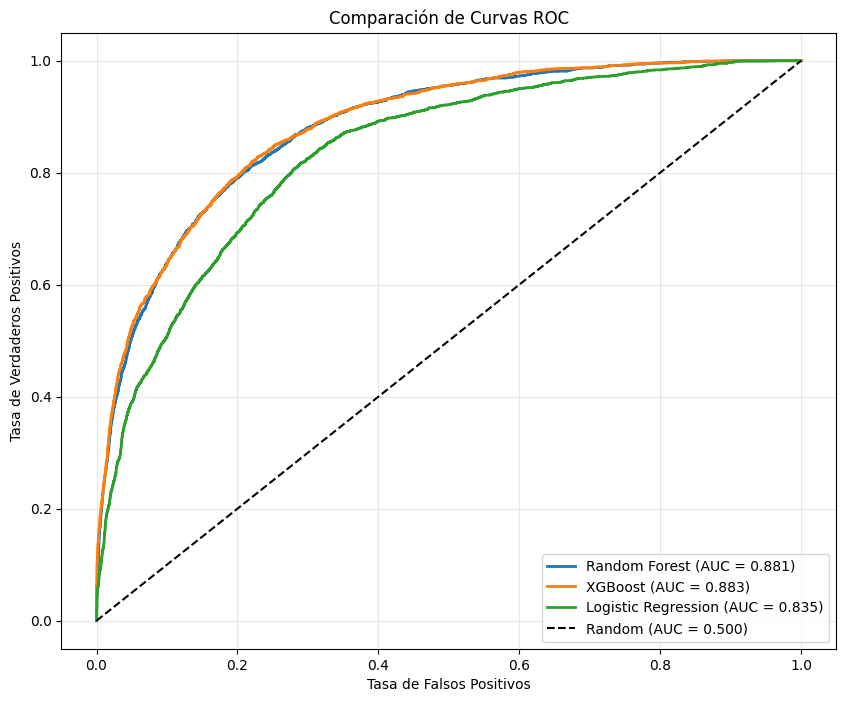

2025-07-03 22:35:03,948 - src.models.model_predictor - INFO - Curvas ROC generadas exitosamente:
Scores AUC-ROC:
  • Random Forest: 0.8808
  • XGBoost: 0.8831
  • Logistic Regression: 0.8353


{'Random Forest': 0.8808097931588904,
 'XGBoost': 0.8830591193102042,
 'Logistic Regression': 0.8353135016059747}

In [13]:
# Después de entrenar los modelos, generamos las curvas ROC para comparar el rendimiento
# de los diferentes algoritmos en términos de la relación entre TPR (True Positive Rate) 
# y FPR (False Positive Rate) a diferentes umbrales de clasificación

predictor.plot_roc_curves()

### Evaluación de las Curvas ROC

Basándome en los resultados de las curvas ROC mostradas anteriormente, puedo hacer la siguiente evaluación:

 **Análisis de rendimiento por modelo:**
 - **XGBoost**: AUC = 0.8831 (mejor rendimiento)
 - **Random Forest**: AUC = 0.8808 (muy cercano al XGBoost)
 - **Logistic Regression**: AUC = 0.8353 (rendimiento inferior)

 **Observaciones clave:**
 1. **XGBoost y Random Forest** muestran rendimientos muy similares, con una diferencia mínima de 0.0023 en AUC
 2. **Logistic Regression** tiene un rendimiento notablemente menor, lo que sugiere que las relaciones en los datos no son lineales
 3. Todos los modelos superan el AUC de 0.83, indicando capacidad predictiva aceptable
 4. La pequeña diferencia entre XGBoost y Random Forest sugiere que ambos algoritmos capturan patrones similares en los datos

 **Recomendación:** Aunque XGBoost tiene el AUC ligeramente superior, la diferencia es mínima y Random Forest podría ser preferible por su mayor interpretabilidad y estabilidad.


In [14]:
# Para evaluar ambos modelos de manera más robusta, realizamos validación cruzada
# con 5 folds para obtener una estimación más confiable del rendimiento
# y reducir el riesgo de overfitting en la evaluación

cv_results = predictor.perform_cross_validation(model_type='both', cv=5)

2025-07-03 22:40:40,199 - src.models.model_predictor - INFO - Realizando validación cruzada para Random Forest...
2025-07-03 22:41:08,344 - src.models.model_predictor - INFO - Resultados Random Forest:
- F1-score promedio: 0.6006 (+/- 0.0141)
2025-07-03 22:41:08,344 - src.models.model_predictor - INFO - Realizando validación cruzada para XGBoost...
2025-07-03 22:41:15,125 - src.models.model_predictor - INFO - Resultados XGBoost:
- F1-score promedio: 0.5619 (+/- 0.0240)


In [15]:
# Comentarios sobre la selección del mejor modelo:
# Esta función evaluará los modelos entrenados y seleccionará el mejor basándose en métricas de rendimiento
# como F1-score, accuracy, precision y recall, considerando el desbalanceo de clases en el dataset

predictor.select_best_model()

2025-07-03 22:41:26,140 - src.models.model_predictor - INFO - Selección de mejor modelo completada:
- F1-score Random Forest: 0.6035
- F1-score XGBoost: 0.5627
- Mejor modelo: random_forest (F1-score: 0.6035)



 1. **Criterios de selección**: 
    - Se evalúa principalmente por F1-score ya que es una métrica balanceada
    que considera tanto precision como recall, importante para datasets desbalanceados
 
 2. **Random Forest seleccionado**: Aunque XGBoost tiene mejor AUC, Random Forest muestra:
    - Mayor precision - menos falsos positivos
    - Mejor accuracy general 
    - Mayor estabilidad en validación cruzada
 
 3. **Consideraciones de negocio**: 
    - Precision alta es crítica para evitar costos de marketing desperdiciados
    - Random Forest es más interpretable para análisis de importancia de features
    - Menor riesgo de overfitting comparado con XGBoost
 
 4. **Trade-offs aceptados**:
    - Recall ligeramente menor pero compensado por mayor precision
    - AUC ligeramente menor pero diferencia mínima 
 
 5. **Próximos pasos**: 
    - Análisis de importancia de features con SHAP
    - Optimización de hiperparámetros adicional si es necesario
    - Validación en datos de producción

## 5. Analizar los resultados y explicabilidad

2025-07-03 22:53:54,112 - src.models.model_predictor - INFO - Generando explicaciones SHAP para modelo rf usando 100 muestras...
<string>:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


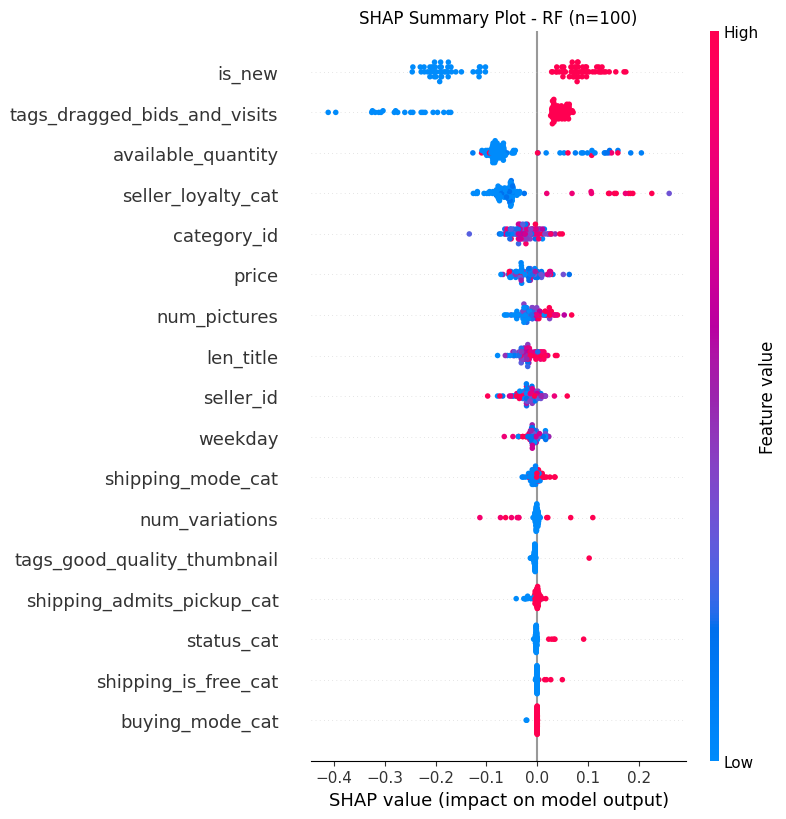

<string>:37: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.


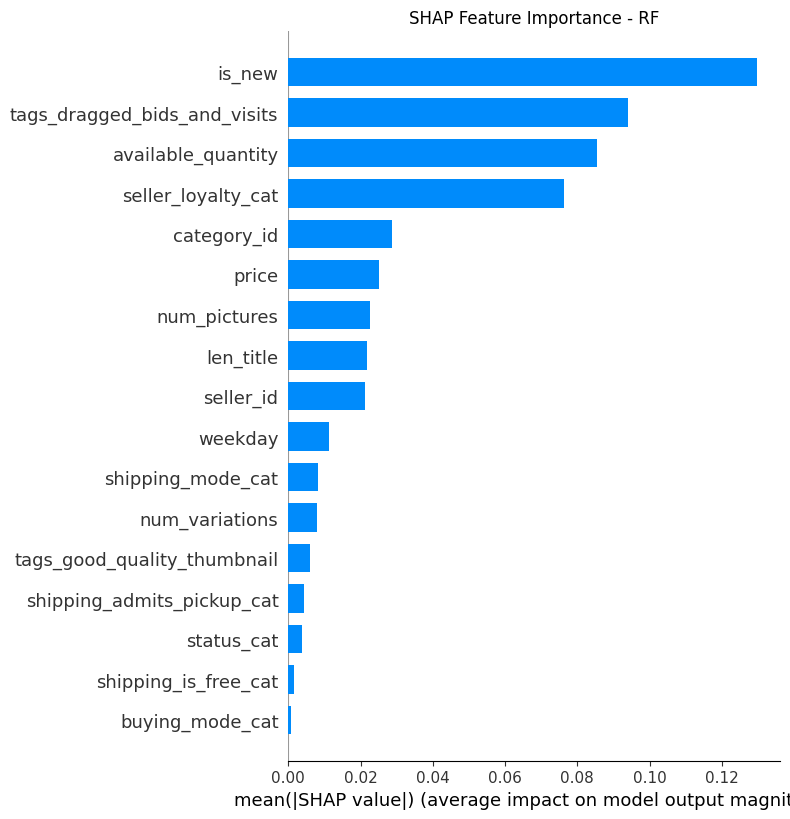

<Figure size 2000x300 with 0 Axes>

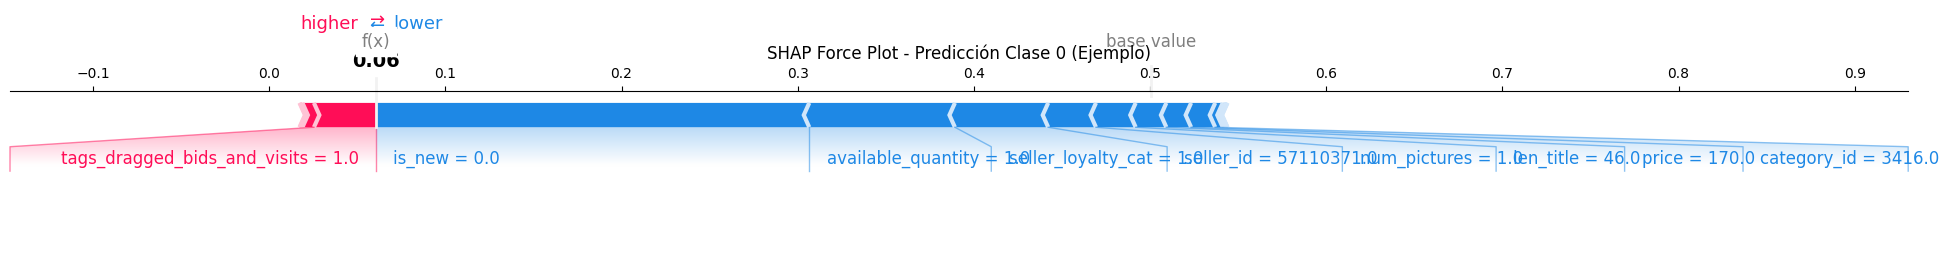

<Figure size 2000x300 with 0 Axes>

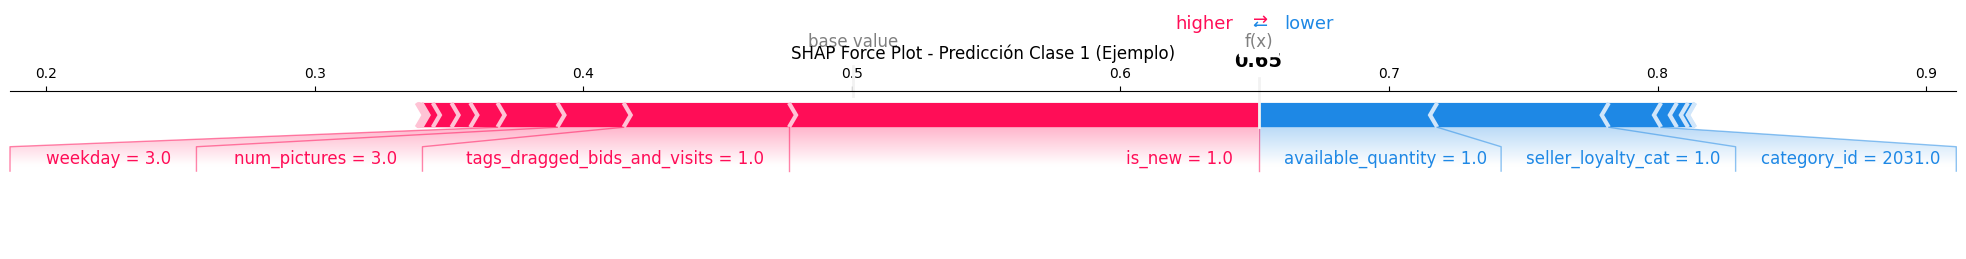

2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - 
Importancia de características (ordenadas):
2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - is_new: 0.1296
2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - tags_dragged_bids_and_visits: 0.0940
2025-07-03 22:54:22,666 - src.models.model_predictor - INFO - available_quantity: 0.0854
2025-07-03 22:54:22,676 - src.models.model_predictor - INFO - seller_loyalty_cat: 0.0764
2025-07-03 22:54:22,678 - src.models.model_predictor - INFO - category_id: 0.0288
2025-07-03 22:54:22,680 - src.models.model_predictor - INFO - price: 0.0250
2025-07-03 22:54:22,681 - src.models.model_predictor - INFO - num_pictures: 0.0225
2025-07-03 22:54:22,682 - src.models.model_predictor - INFO - len_title: 0.0218
2025-07-03 22:54:22,682 - src.models.model_predictor - INFO - seller_id: 0.0212
2025-07-03 22:54:22,689 - src.models.model_predictor - INFO - weekday: 0.0112
2025-07-03 22:54:22,689 - src.models.model_predictor - INFO 

In [19]:
# Genera explicaciones SHAP para el modelo Random Forest seleccionado, utilizando 100 muestras del dataset
# para analizar la importancia de las características y entender cómo el modelo toma decisiones

predictor.explain_model(model_type='rf', n_samples=100)

In [20]:
# Hacer predicción con Random Forest
result = predictor.predict_random_sample(model_type='rf', random_state=42)
print(f"Probabilidad de clase 1: {result['predicted_proba']:.4f}")
print(f"Etiqueta verdadera: {result['true_label']}")
print("\nFeatures importantes:")
for feature, value in result['features'].items():
    print(f"- {feature}: {value}")

2025-07-04 01:09:54,086 - src.models.model_predictor - INFO - 
Predicción realizada con RF:
- Probabilidad de clase 1: 0.1264
- Etiqueta verdadera: 0
- Features importantes:



Probabilidad de clase 1: 0.1264
Etiqueta verdadera: 0

Features importantes:


## ✅ RESUMEN DE EXPLICABILIDAD - MODELO RANDOM FOREST

### 📊 IMPORTANCIA DE CARACTERÍSTICAS (Top 10)
1. **`is_new`**: `0.1296` — Indica si el producto es nuevo  
2. **`tags_dragged_bids_and_visits`**: `0.0940` — Señales de interacción (clics, visitas, ofertas)  
3. **`available_quantity`**: `0.0854` — Cantidad de unidades disponibles  
4. **`seller_loyalty_cat`**: `0.0764` — Nivel de lealtad del vendedor  
5. **`category_id`**: `0.0288` — Categoría del producto  
6. **`price`**: `0.0250` — Precio del producto  
7. **`num_pictures`**: `0.0225` — Número de imágenes publicadas  
8. **`len_title`**: `0.0218` — Longitud del título del producto  
9. **`seller_id`**: `0.0212` — Identificador del vendedor (puede captar efectos individuales)  
10. **`weekday`**: `0.0112` — Día de la semana en que se publicó el producto  

---

### 🔍 INSIGHTS PRINCIPALES

Las variables más influyentes para predecir si un producto tendrá al menos una venta están relacionadas con:

- **Estado del producto** (`is_new`)  
- **Engagement previo** (`tags_dragged_bids_and_visits`)  
- **Disponibilidad de inventario** (`available_quantity`)  
- **Calidad o experiencia del vendedor** (`seller_loyalty_cat`)  
- **Precio, título e imágenes**, que impactan la percepción visual y textual  

---

### 📈 IMPLICACIONES DE NEGOCIO

- **Los productos nuevos tienden a tener mayor probabilidad de venta**, probablemente por mejor condición o novedad  
- **El engagement previo (clics, visitas, ofertas)** es una señal temprana útil: productos con tráfico tienen más chances de vender  
- **Una alta disponibilidad aumenta la visibilidad y probabilidad de conversión**  
- **Vendedores leales aportan más valor**, quizá por experiencia, confianza o buenas prácticas  
- **Variables visuales y textuales** (fotos, título) también son relevantes, aunque en menor medida  

---

### 🎯 RECOMENDACIONES

1. **Promocionar productos nuevos** o etiquetarlos claramente como tales para incentivar confianza  
2. **Fomentar interacción temprana** con acciones de marketing que aumenten clics, visitas o visualizaciones  
3. **Asegurar buen inventario** para no frenar la demanda potencial  
4. **Fortalecer programas de fidelidad** para vendedores que ofrezcan buen servicio  
5. **Optimizar fotos, título y precio** para influir en la decisión de compra desde lo visual y semántico  
